In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import itertools

np.random.seed(1)

# p : X -> [0,1]
# Sigmoid function is monotonic
def p(x) -> float:
    return 1 / (1 + np.exp(-x))

def expected(x, plus, minus):
    return p(x) * plus + (1-p(x)) * minus

#Vectorized optimal step
def opt_step(X, u_plus, u_minus, c_plus, c_minus):

    # Samples
    # All operations are performed on array-like structures
    X = np.asarray(X)

    # Calculate utility and predicted change of all samples
    exp_util = expected(X, u_plus, u_minus) 
    delta_x = expected(X, c_plus, c_minus)

    # Add predicted change to sample if utility is positive else return sample
    max_util = np.where(exp_util > 0, X + delta_x, X) 

    # Smallest threshold where utility is positive
    thresholds = X[exp_util > 0]
    opt_thresh = np.min(thresholds) if thresholds.size > 0 else None

    # array of updated samples, min sample whose util is positive
    return (max_util, opt_thresh)

def change(A, B, c_plus, c_minus, u_plus, u_minus, prob=0.4):
    
    # Working with array-like structures
    A = np.asarray(A)
    B = np.asarray(B)

    # Calculated predicted change of both sets of samples
    delta_A = expected(A, c_plus, c_minus)
    delta_B = expected(B, c_plus, c_minus)

    A_matrix = np.repeat(A, A.shape[0]).reshape((A.shape[0], A.shape[0]))
    B_matrix = np.repeat(B, B.shape[0]).reshape((B.shape[0], B.shape[0]))
    delta_A_matrix = np.repeat(delta_A, A.shape[0]).reshape((A.shape[0], A.shape[0]))
    delta_B_matrix = np.repeat(delta_B, B.shape[0]).reshape((B.shape[0], B.shape[0]))

    jitter = np.random.choice([1e-8, -1e-8], size=A.shape, p=[0.4, 0.6])
    noise = (A_matrix + delta_A_matrix) == A_matrix.T
    A_matrix = np.where(noise, A_matrix + jitter, A_matrix)
    noise = (B_matrix + delta_B_matrix) == B_matrix.T
    B_matrix = np.where(noise, B_matrix + jitter, B_matrix)
    
    A_matrix = np.where(A_matrix + delta_A_matrix > A_matrix.T, A_matrix + delta_A_matrix, A_matrix)
    B_matrix = np.where(B_matrix + delta_B_matrix > B_matrix.T, B_matrix + delta_B_matrix, B_matrix)

    mean_A = np.mean(A_matrix, axis=0)
    mean_B = np.mean(B_matrix, axis=0)
    mean_A = np.repeat(mean_A, mean_A.shape[0]).reshape((mean_A.shape[0], mean_A.shape[0]))
    mean_B = np.repeat(mean_B, mean_B.shape[0]).reshape((mean_B.shape[0], mean_B.shape[0])).T

    util_A = np.sum(expected(A_matrix, u_plus, u_minus), axis=0)
    util_B = np.sum(expected(B_matrix, u_plus, u_minus), axis=0)
    util_A = np.repeat(util_A, util_A.shape[0]).reshape((util_A.shape[0], util_A.shape[0]))
    util_B = np.repeat(util_B, util_B.shape[0]).reshape((util_B.shape[0], util_B.shape[0]))

    return mean_A, mean_B, util_A, util_B

def fair_opt_step(A, B, u_plus, u_minus, c_plus, c_minus, alpha):
    
    # Working with array-like structures
    A = np.array(A)
    B = np.array(B)
    np.random.seed(1)
    prob = 0.4

    # Calculate population percentages
    w_a = len(A) / (len(A) + len(B))
    w_b = 1 - w_a

    # Build meshgrid for threshold pairs
    mean_A, mean_B = np.meshgrid(A, B, indexing='ij')
    util_A, util_B = np.meshgrid(A, B, indexing='ij')

    # Matrix of every threshold combination
    mean_A, mean_B, util_A, util_B = change(A, B, c_plus, c_minus, u_plus, u_minus, prob)

    # Calculate fairness difference at each pair
    fairness_diff = np.abs(mean_A - mean_B)

    # Calculate weighted total utility for each pair
    total_util = w_a * util_A + w_b * util_B

    # Mask utilities violating fairness constraint
    copy = total_util.copy()
    total_util[fairness_diff > alpha] = -np.inf
    fair_util = total_util.copy()
    total_util = copy

    flat_idx = np.argmax(total_util)
    i_idx, j_idx = np.unravel_index(flat_idx, total_util.shape)

    opt_A = A[i_idx]  # index along A dimension
    opt_B = B[j_idx]  # index along B dimension

    updated_samples = (mean_A[i_idx, j_idx], mean_B[i_idx, j_idx])  # updated after change

    max_util = total_util[i_idx, j_idx]

    return (opt_A, opt_B, max_util, updated_samples, total_util)


In [ ]:
# Fairness optimization with varying alpha values
# This code optimizes the means of two distributions A and B under a fairness constraint defined by alpha.

import numpy as np
import matplotlib.pyplot as plt

# Distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1

# Range of alpha values to test
alpha_min, alpha_max = 0, 2
alphas = np.linspace(alpha_min, alpha_max, num=100)

# Sample size of each distribution
sample_size = 3000

# Generate samples from normal distributions
np.random.seed(1)
a = np.random.normal(mean_a, std_a, sample_size)
b = np.random.normal(mean_b, std_b, sample_size)

# Store results
x = []
fair_mean_A = []
fair_mean_B = []

# Unconstrained optimal means
opt_result_A = opt_step(a, 1, -1, 1, -1)[0]
opt_result_B = opt_step(b, 1, -1, 1, -1)[0]
y3 = np.mean(opt_result_A)
y4 = np.mean(opt_result_B)

# Run fair optimization over a range of alpha values
for alpha in alphas:
    updated_samples = fair_opt_step(a, b, 1, -1, 1, -1, alpha)[3]
    if updated_samples is not None:
        A, B = updated_samples
        if np.abs(np.mean(A) - np.mean(B)) > alpha:
            # Only store results if the fairness constraint is satisfied
            continue
        x.append(alpha)
        fair_mean_A.append(A)
        fair_mean_B.append(B)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, fair_mean_A, label="Fair μ(A)'", color='red')
plt.plot(x, fair_mean_B, label="Fair μ(B)'", color='blue')
plt.axhline(y3, color='red', linestyle='--', label='Optimal μ(A)\' (Unconstrained)')
plt.axhline(y4, color='blue', linestyle='--', label='Optimal μ(B)\' (Unconstrained)')
plt.plot(0, mean_a, 'ro', label='Initial μ(A)')
plt.plot(0, mean_b, 'bo', label='Initial μ(B)')

plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
plt.xlabel("α (Fairness Threshold)")
plt.ylabel("Mean Value after Optimization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


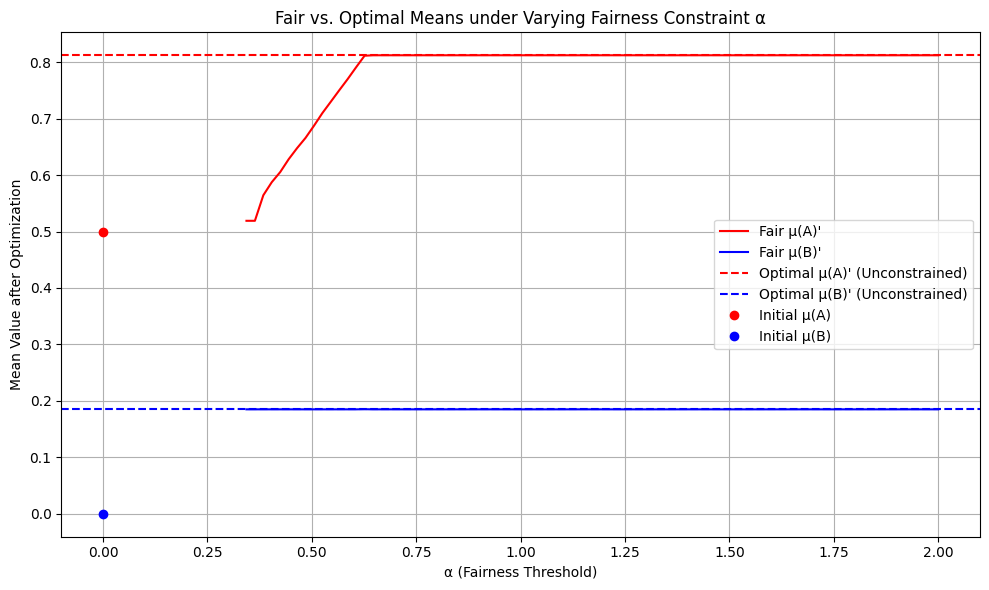

In [26]:
# Fairness optimization with varying alpha values
# This code optimizes the means of two distributions A and B under a fairness constraint defined by alpha.

import numpy as np
import matplotlib.pyplot as plt

# Distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1

# Range of alpha values to test
alpha_min, alpha_max = 0, 2
alphas = np.linspace(alpha_min, alpha_max, num=100)

# Sample size of each distribution
# 2000 samples : 1m 47.9s
# 3000 samples : 4m 17.6s
sample_size = 3000

# Generate samples from normal distributions
np.random.seed(1)
a = np.random.normal(mean_a, std_a, sample_size)
b = np.random.normal(mean_b, std_b, sample_size)

# Store results
x = []
fair_mean_A = []
fair_mean_B = []

# Unconstrained optimal means
opt_result_A = opt_step(a, 1, -1, 1, -1)[0]
opt_result_B = opt_step(b, 1, -1, 1, -1)[0]
y3 = np.mean(opt_result_A)
y4 = np.mean(opt_result_B)

# Run fair optimization over a range of alpha values
for alpha in alphas:
    updated_samples = fair_opt_step(a, b, 1, -1, 1, -1, alpha)[3]
    if updated_samples is not None:
        A, B = updated_samples
        if np.abs(np.mean(A) - np.mean(B)) > alpha:
            # Only store results if the fairness constraint is satisfied
            continue
        x.append(alpha)
        fair_mean_A.append(A)
        fair_mean_B.append(B)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, fair_mean_A, label="Fair μ(A)'", color='red')
plt.plot(x, fair_mean_B, label="Fair μ(B)'", color='blue')
plt.axhline(y3, color='red', linestyle='--', label='Optimal μ(A)\' (Unconstrained)')
plt.axhline(y4, color='blue', linestyle='--', label='Optimal μ(B)\' (Unconstrained)')
plt.plot(0, mean_a, 'ro', label='Initial μ(A)')
plt.plot(0, mean_b, 'bo', label='Initial μ(B)')

plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
plt.xlabel("α (Fairness Threshold)")
plt.ylabel("Mean Value after Optimization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


0.00157209891452037 0.00048017980943572554 -0.0010919191050846446


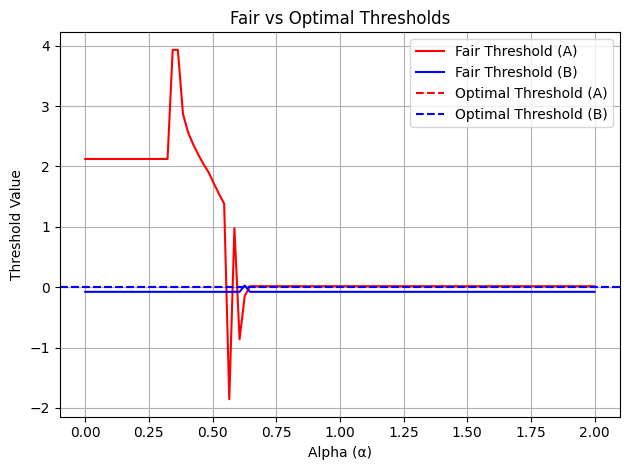

In [ ]:
### Plotting the Fair Thresholds and Optimal Thresholds

# Define distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1

# Set sample size
# Runtime for different sample sizes:
# 1000 samples, 21 alphas : 7s
# 2000 samples, 21 alphas : 32.1s
# 3000 samples, 21 alphas : 52.4s
# 4000 samples, 21 alphas : 1m 41.1s
# 5000 samples, 21 alphas : 2m 28.0s
# 3000 samples, 100 alphas : 4m 46.3s
# 5000 samples, 100 alphas : 11m+

sample_size = 3000

# Generate samples from normal distributions
np.random.seed(1)
a = np.random.normal(mean_a, std_a, sample_size)
b = np.random.normal(mean_b, std_b, sample_size)

# Range of alpha values to test
alpha_min, alpha_max = 0, 2
alphas = np.linspace(alpha_min, alpha_max, num=100)

x = []
y1 = []
y2 = []
y3 = opt_step(a, 1, -1, 1, -1)[1]
y4 = opt_step(b, 1, -1, 1, -1)[1]

for i in alphas:
    results = fair_opt_step(a, b, 1, -1, 1, -1, alpha=i)
    if results[0] is not None and results[1] is not None:
        
        # Only store results if the fairness constraint is satisfied
        if np.abs(np.mean(A) - np.mean(B)) > alpha:
            continue
        
        x.append(i)
        y1.append(results[0])
        y2.append(results[1])
    '''
    else:
        x1.append(i)
        y1.append(-1)
        y2.append(-1)
    '''
print(y3, y4, y4-y3)
plt.plot(x, y1, label="Fair Threshold (A)", color='red')
plt.plot(x, y2, label="Fair Threshold (B)", color='blue')
plt.axhline(y3, color='red', linestyle='--', label='Optimal Threshold (A)')
plt.axhline(y4, color='blue', linestyle='--', label='Optimal Threshold (B)')

plt.title("Fair vs Optimal Thresholds")
plt.xlabel("Alpha (α)")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.tight_layout()


In [ ]:
print(y4)

5.300824315524947e-05


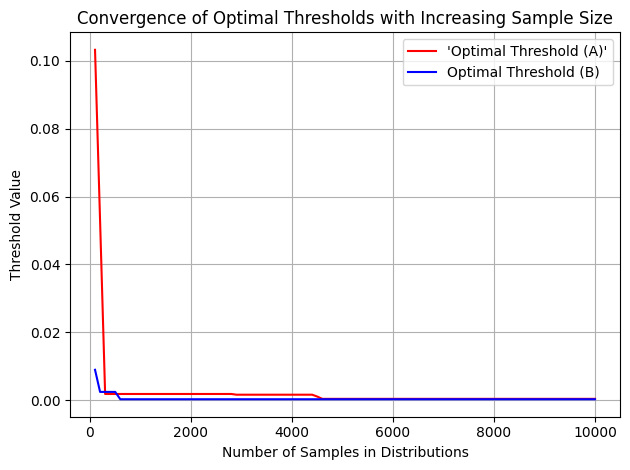

In [ ]:
### Question: Will the optimal thresholds of populations A and B converge with enough samples? ###
### If true, how many samples are needed? ###

#Define distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1

#Generate all samples
sample_size = 10000
intervals = list(range(100, sample_size + 1, 100))
np.random.seed(1)
A = np.random.normal(mean_a, std_a, sample_size)
B = np.random.normal(mean_b, std_b, sample_size)

x = []
y1 = []
y2 = []
y3 = []

#For each subset of samples
for i in intervals:
    a = A[:i]
    b = B[:i]
    t_a, t_b = opt_step(a, 1, -1, 1, -1)[1], opt_step(b, 1, -1, 1, -1)[1] 
    if t_a is not None and t_b is not None:
        x.append(i)
        y1.append(t_a)
        y2.append(t_b)
        y3.append(np.abs(y2[-1] - y1[-1]))

# Plotting
plt.plot(x, y1, label="'Optimal Threshold (A)'", color='red')
plt.plot(x, y2, label='Optimal Threshold (B)', color='blue')

plt.title("Convergence of Optimal Thresholds with Increasing Sample Size")
plt.xlabel("Number of Samples in Distributions")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


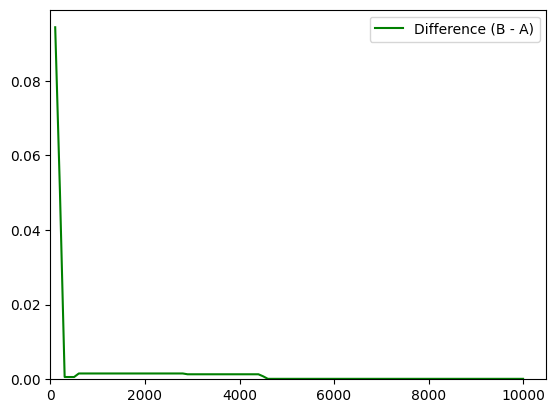

In [ ]:
plt.plot(x, y3, label='Difference (B - A)', color='green')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()

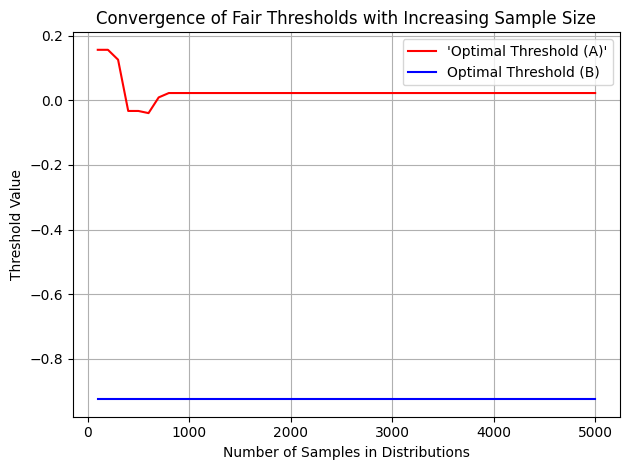

In [37]:
### Question: Will the optimal thresholds of populations A and B converge with enough samples? ###
### If true, how many samples are needed? ###

#Define distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1

#Generate all samples
sample_size = 5000
intervals = list(range(100, sample_size + 1, 100))
np.random.seed(1)
A = np.random.normal(mean_a, std_a, sample_size)
B = np.random.normal(mean_b, std_b, sample_size)

x = []
y1 = []
y2 = []
y3 = []

#For each subset of samples
for i in intervals:
    a = A[:i]
    b = B[:i]
    results = fair_opt_step(a, b, 1, -1, 1, -1, alpha=2)
    t_a, t_b = results[0], results[1]
    # Check if the thresholds are valid
    if t_a is not None and t_b is not None:
        x.append(i)
        y1.append(t_a)
        y2.append(t_b)
        y3.append(np.abs(y2[-1] - y1[-1]))

# Plotting
plt.plot(x, y1, label="'Optimal Threshold (A)'", color='red')
plt.plot(x, y2, label='Optimal Threshold (B)', color='blue')

plt.title("Convergence of Fair Thresholds with Increasing Sample Size")
plt.xlabel("Number of Samples in Distributions")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

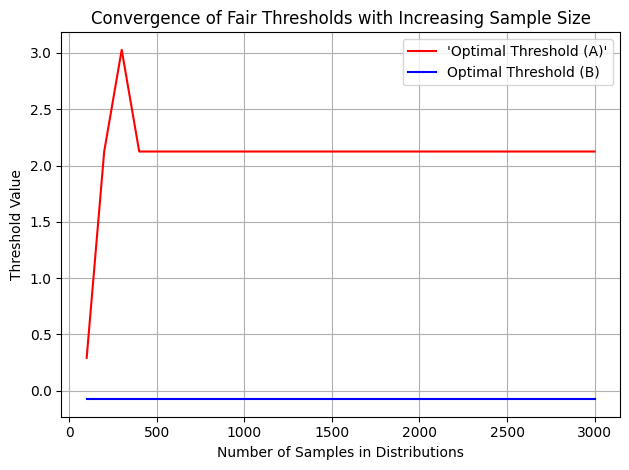

In [42]:
### Question: Will the optimal thresholds of populations A and B converge with enough samples? ###
### If true, how many samples are needed? ###

#Define distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1

#Generate all samples
sample_size = 3000
intervals = list(range(100, sample_size + 1, 100))
np.random.seed(1)
A = np.random.normal(mean_a, std_a, sample_size)
B = np.random.normal(mean_b, std_b, sample_size)

x = []
y1 = []
y2 = []
y3 = []

#For each subset of samples
for i in intervals:
    a = A[:i]
    b = B[:i]
    results = fair_opt_step(a, b, 1, -1, 1, -1, alpha=0.3)
    t_a, t_b = results[0], results[1]
    # Check if the thresholds are valid
    if t_a is not None and t_b is not None:
        x.append(i)
        y1.append(t_a)
        y2.append(t_b)
        y3.append(np.abs(y2[-1] - y1[-1]))

# Plotting
plt.plot(x, y1, label="'Optimal Threshold (A)'", color='red')
plt.plot(x, y2, label='Optimal Threshold (B)', color='blue')

plt.title("Convergence of Fair Thresholds with Increasing Sample Size")
plt.xlabel("Number of Samples in Distributions")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()